In [9]:
from bp import FactorGraph, Loopy_BP

import numpy as np
import matplotlib.pyplot as plt

import pickle, os

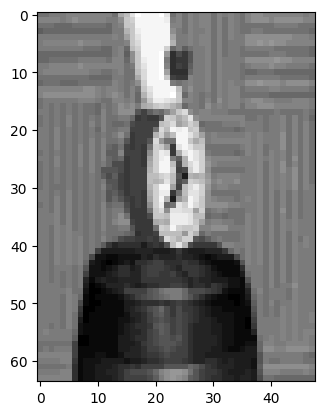

In [10]:
with open('test_image.pkl', 'rb') as f:
    image = pickle.load(f, encoding="latin1").astype(int)

plt.imshow(image, cmap='gray')

In [11]:
Npxl = 32
distrib_int_obs = np.zeros((Npxl, 2)) + .1
distrib_int_obs[13:17, 1] = 1
distrib_int_obs[:13, 0] = 1
distrib_int_obs[17:, 0] = 1

distrib_clc_neigh = np.array([[1, .1], [.1, 1]])



In [12]:
g = FactorGraph()

image_shape = image.shape
for i, j in np.ndindex(image_shape):
    obs = np.zeros(Npxl)
    obs[int(image[i, j])] = 1

    obs_name = 'obs({}, {})'.format(i, j)
    clc_name = 'cls({}, {})'.format(i, j)

    g.add_variable_node(obs_name, Npxl, obs)
    g.add_variable_node(clc_name, 2)
    
    g.add_factor_node('int_obs({},{})'.format(i, j), [obs_name, clc_name], distrib_int_obs)

for i, j in np.ndindex(image_shape):
    if i+1 < image_shape[0]:
        g.add_factor_node('{}\n{}'.format((i, j), (i+1, j)), ['cls({}, {})'.format(i, j), 'cls({}, {})'.format(i+1, j)], distrib_clc_neigh)
    if j+1 < image_shape[1]:   
        g.add_factor_node('{}\n{}'.format((i, j), (i, j+1)), ['cls({}, {})'.format(i, j), 'cls({}, {})'.format(i, j+1)], distrib_clc_neigh)


In [13]:
N = 50
beliefs_loppy = []

lbp = Loopy_BP(g)

for i in range(N) :
    lbp.loop()
    beliefs = np.array([lbp.belief('cls({}, {})'.format(i, j)) for i, j in np.ndindex(image_shape)])
    beliefs_loppy.append(beliefs[:, 1].reshape(image_shape))    

    # fig, ax = plt.subplots(1, 1)
    # ax.set_title('loppy_BP : {}'.format(i+1))
    # im = ax.imshow(beliefs_loppy[-1], cmap='gray', vmin=0, vmax=1)
    # fig.colorbar(im, ax=ax)


    # fig.savefig(os.path.join('loopy_BP_gif','{}.png'.format(i)))

# preds = np.argmax(beliefs, axis=-1).reshape(image_shape)
# plt.imshow(1-preds, cmap='gray')

In [14]:

class URW_BP(Loopy_BP):
    def __init__(self, model:FactorGraph, rho=.5):
        super().__init__(model)
        # self.model = model
        # self.msg = {}
        # self.msg_new = {}
        # self.t = 0
        # self.init_msg()

        self.rho = rho


    def _compute_var2fact_msg(self, var, fact) :
        in_msgs = []
        for f_name in self.model.g.neighbors(var):
            if f_name != fact:
                msg = self.get_fact2var_msg(f_name, var)
                msg = np.power(msg, self.rho)
                in_msgs.append(msg)
        
        if len(in_msgs) == 0:
            distrib = self.model.g.nodes[var]['distrib']
        else:
            distrib = np.array(in_msgs).prod(axis=0)

        msg = self.get_fact2var_msg(fact, var)
        distrib = distrib * np.power(msg, self.rho-1)

        distrib /= distrib.sum()
        return distrib


        
    def _compute_fact2var_msg(self, fact, var) :
        distrib = self.model.g.nodes[fact]['distrib']
        distrib = np.power(distrib, 1./self.rho)

        linked_vars = self.model.g.nodes[fact]['variables']

        for v_name in linked_vars[::-1]:
            if v_name != var:
                in_msg = self.get_var2fact_msg(v_name, fact)
                distrib = (distrib * in_msg).sum(axis=-1)

            else :
                distrib = np.moveaxis(distrib, -1, 0)   

        distrib /= distrib.sum() 
        return distrib

In [ ]:
beliefs_URW_bp = []

lbp = URW_BP(g)

for i in range(N) :
    lbp.loop()
    beliefs = np.array([lbp.belief('cls({}, {})'.format(i, j)) for i, j in np.ndindex(image_shape)])
    beliefs_URW_bp.append(beliefs[:, 1].reshape(image_shape))    


    fig, ax = plt.subplots(1, 1)
    ax.set_title('URW-BP : {}'.format(i+1))
    im = ax.imshow(beliefs_URW_bp[-1], cmap='gray', vmin=0, vmax=1)
    fig.colorbar(im, ax=ax)


    fig.savefig(os.path.join('URW_BP_gif','{}.png'.format(i)))

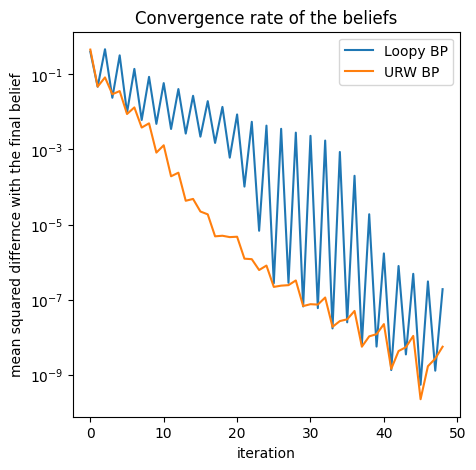

In [20]:
loopy_bp_evol = np.zeros(N-1)
URW_bp_evol = np.zeros(N-1)

for i in range(N-1):
    loopy_bp_evol[i] = np.mean((beliefs_loppy[i] - beliefs_loppy[-1])**2)
    URW_bp_evol[i] = np.mean((beliefs_URW_bp[i] - beliefs_URW_bp[-1])**2)

plt.figure(figsize=(5, 5))
plt.yscale('log')   
plt.title('Convergence rate of the beliefs')
plt.xlabel('iteration')
plt.ylabel('mean squared differnce with the final belief')
plt.plot(loopy_bp_evol, label='Loopy BP')
plt.plot(URW_bp_evol, label='URW BP')
plt.legend()
plt.show()




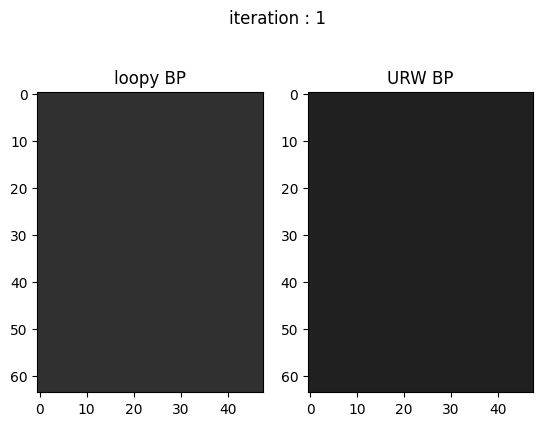

In [10]:
from matplotlib.animation import FuncAnimation


beliefs0 = beliefs_loppy[0]
beliefs1 = beliefs_URW_bp[0]

# Create a figure and axis
fig, (ax0, ax1) = plt.subplots(1, 2)
suptitle = fig.suptitle('iteration : 1')
ax0.set_title('loopy BP')
ax1.set_title('URW BP')

# Initialize the imshow plot with the first frame of data
im0 = ax0.imshow(beliefs0, cmap='grey', vmin=0, vmax=1)
im1 = ax1.imshow(beliefs1, cmap='grey', vmin=0, vmax=1)

# Function to update the plot for each frame of the animation
def update(frame):
    suptitle.set_text('iteration : {}'.format(frame+1))
    im0.set_array(beliefs_loppy[frame])  
    im1.set_array(beliefs_URW_bp[frame])
    return suptitle, im0, im1

# Create the animation
ani = FuncAnimation(fig, update, frames=range(N))  


# Save the animation as a gif
ani.save('loopy_URW.gif', writer='pillow', fps=2)  # Adjust fps as needed


In [12]:
rhos = np.linspace(0.1, 1, 10)
beliefs_URW_bp_rho = []

for rho in rhos:
    beliefs_URW_bp_temp = []

    lbp = URW_BP(g, rho=rho)

    for i in range(N) :
        lbp.loop()
        beliefs = np.array([lbp.belief('cls({}, {})'.format(i, j)) for i, j in np.ndindex(image_shape)])
        beliefs_URW_bp_temp.append(beliefs[:, 1].reshape(image_shape))    
    beliefs_URW_bp_rho.append(beliefs_URW_bp_temp)


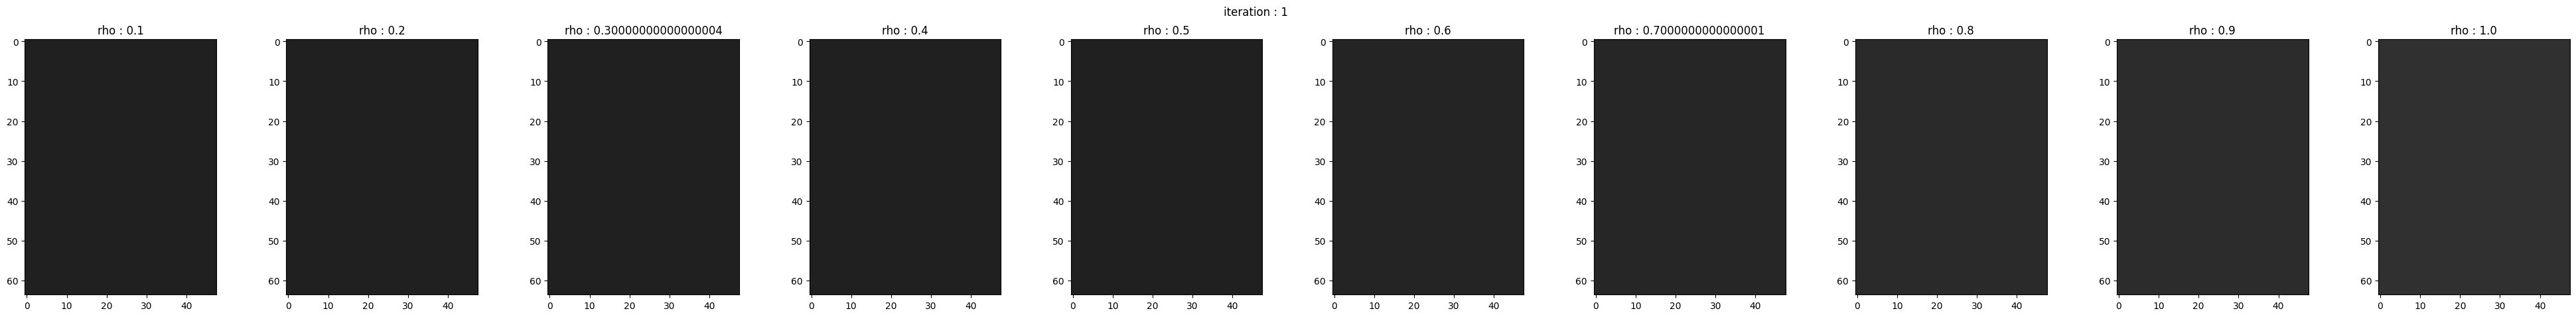

In [14]:
N_rho = len(rhos)



# Create a figure and axis
fig, axs = plt.subplots(1, N_rho, figsize=(5*N_rho, 5))
ims = []


suptitle = fig.suptitle('iteration : 1')
for i, ax in enumerate(axs):
    ax.set_title('rho : {}'.format(rhos[i]))
    im = ax.imshow(beliefs_URW_bp_rho[i][0], cmap='grey', vmin=0, vmax=1)
    ims.append(im)


# Function to update the plot for each frame of the animation
def update(frame):
    suptitle.set_text('iteration : {}'.format(frame+1))

    for i, im in enumerate(ims):
        im.set_array(beliefs_URW_bp_rho[i][frame])
    return suptitle, im0, im1

# Create the animation
ani = FuncAnimation(fig, update, frames=range(N))  


# Save the animation as a gif
ani.save('rho_comparaison.gif', writer='pillow', fps=2)  # Adjust fps as needed
